In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import tempfile

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, \
                            precision_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

In [3]:
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
le = LabelEncoder()

customer_data['Churn'] = le.fit_transform(customer_data['Churn'])

In [6]:
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [7]:
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [8]:
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [9]:
print('Total: {}\n    Positive: {:.2f}\n    Negative: {:.2f}\n'.format(customer_data.shape[0],
                                                         customer_data['Churn'].value_counts(normalize=True)[1],
                                                         customer_data['Churn'].value_counts(normalize=True)[0]))

Total: 7032
    Positive: 0.27
    Negative: 0.73



In [10]:
target = customer_data.pop('Churn')

customer_data_dum = pd.get_dummies(customer_data, columns=customer_data.select_dtypes(include='object').columns,
                                                   drop_first=True)

customer_data_dum['Churn'] = target

In [11]:
train_data, test_data = train_test_split(customer_data_dum, test_size=0.2, stratify=customer_data_dum['Churn'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Churn'])

In [12]:
train_data.head()

,Tenure,MonthlyCharges,TotalCharges,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_CrCa-A,PaymentMethod_ElCh,PaymentMethod_MaCh,Churn
2926,69,116.00,8182.85,0,0,1,0,1,0,1,...,1,0,1,0,1,1,0,1,0,0
6120,6,59.45,357.60,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
711,20,81.00,1683.70,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
633,10,20.35,176.30,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
5779,39,95.55,3692.85,0,0,0,0,1,0,0,...,1,0,0,1,0,1,0,1,0,1


In [13]:
train_labels = np.array(train_data.pop('Churn'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('Churn'))
test_labels = np.array(test_data.pop('Churn'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)
test_features = np.array(test_data)

In [14]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', validation_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4500,)
Validation labels shape: (1125,)
Test labels shape: (1407,)
Training features shape: (4500, 30)
Validation features shape: (1125, 30)
Test features shape: (1407, 30)


/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Negative distribution')

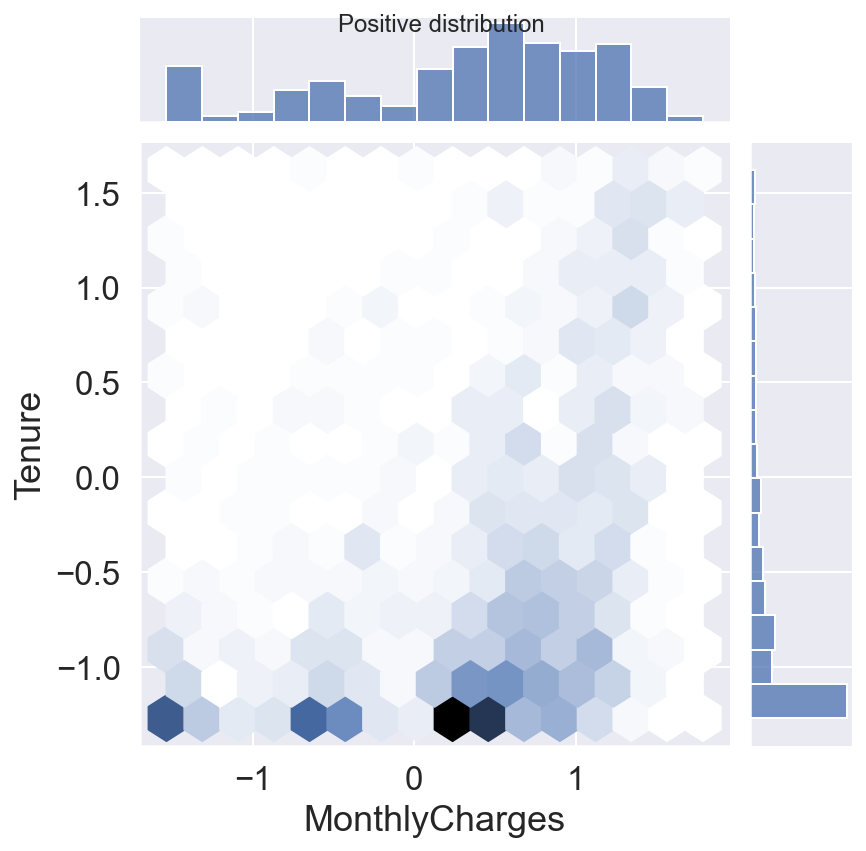

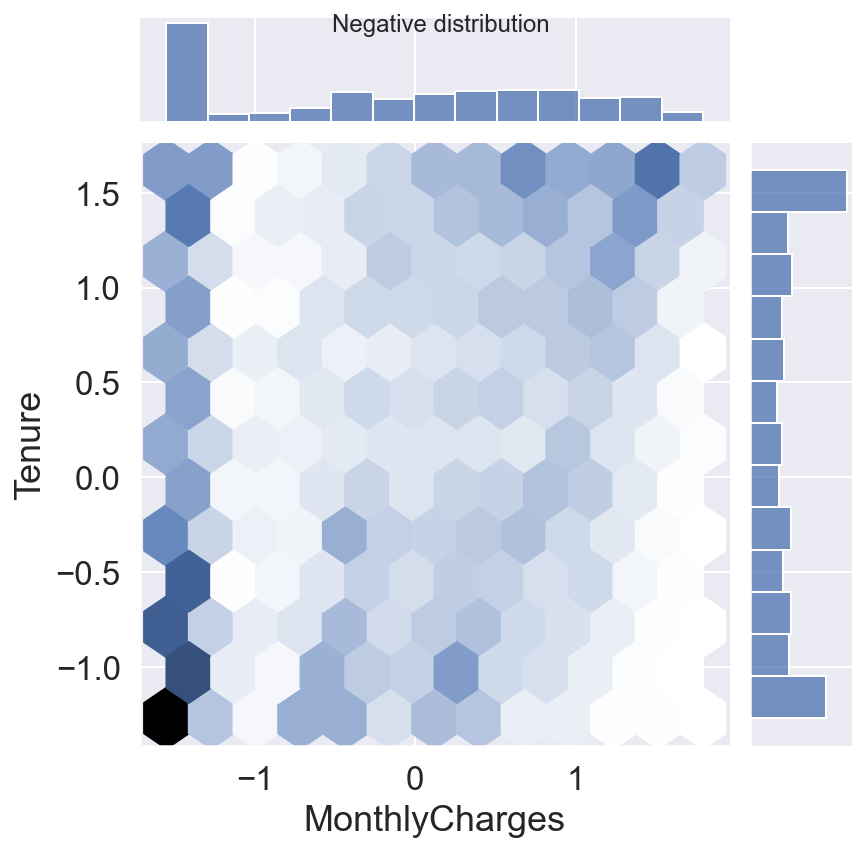

In [15]:
pos_data = pd.DataFrame(train_features[bool_train_labels], columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], columns=train_data.columns)

sns.jointplot(pos_data['MonthlyCharges'], pos_data['Tenure'], kind='hex')
plt.suptitle('Positive distribution')

sns.jointplot(neg_data['MonthlyCharges'], neg_data['Tenure'], kind='hex')
plt.suptitle('Negative distribution')

In [16]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR'),]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(24, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias),
                             ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                  verbose=1,
                                                  patience=15,
                                                  mode='max',
                                                  restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


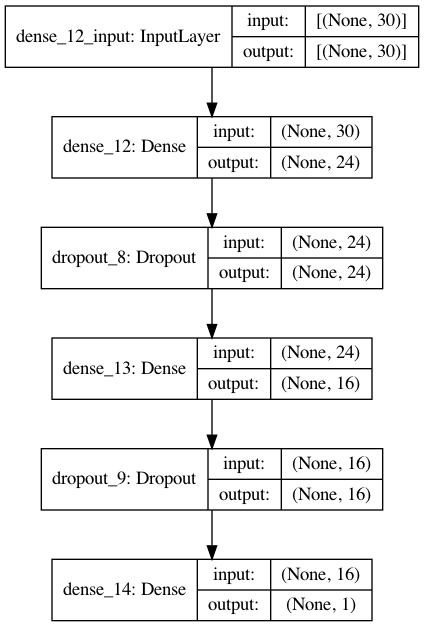

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')

In [19]:
model.predict(train_features[:10])

array([[0.45977408],
       [0.7191052 ],
       [0.5742309 ],
       [0.6182262 ],
       [0.5636698 ],
       [0.5794803 ],
       [0.6867932 ],
       [0.76090133],
       [0.61604345],
       [0.6246695 ]], dtype=float32)

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.7540


In [21]:
neg, pos = np.bincount(customer_data_dum['Churn'])

total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.01611428])

In [22]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.11621195],
       [0.26618838],
       [0.24564958],
       [0.26155564],
       [0.13080576],
       [0.23662183],
       [0.41030985],
       [0.29209608],
       [0.2392993 ],
       [0.3172453 ]], dtype=float32)

In [23]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.5855


In [24]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [25]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(validation_features, validation_labels),
                              verbose=0)

In [26]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features,
                                 train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_data=(validation_features, validation_labels),
                                 verbose=0)

In [27]:
def PlotLoss(history, label, color):
    plt.semilogy(history.epoch, history.history['loss'], color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=color, label='Validation ' + label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

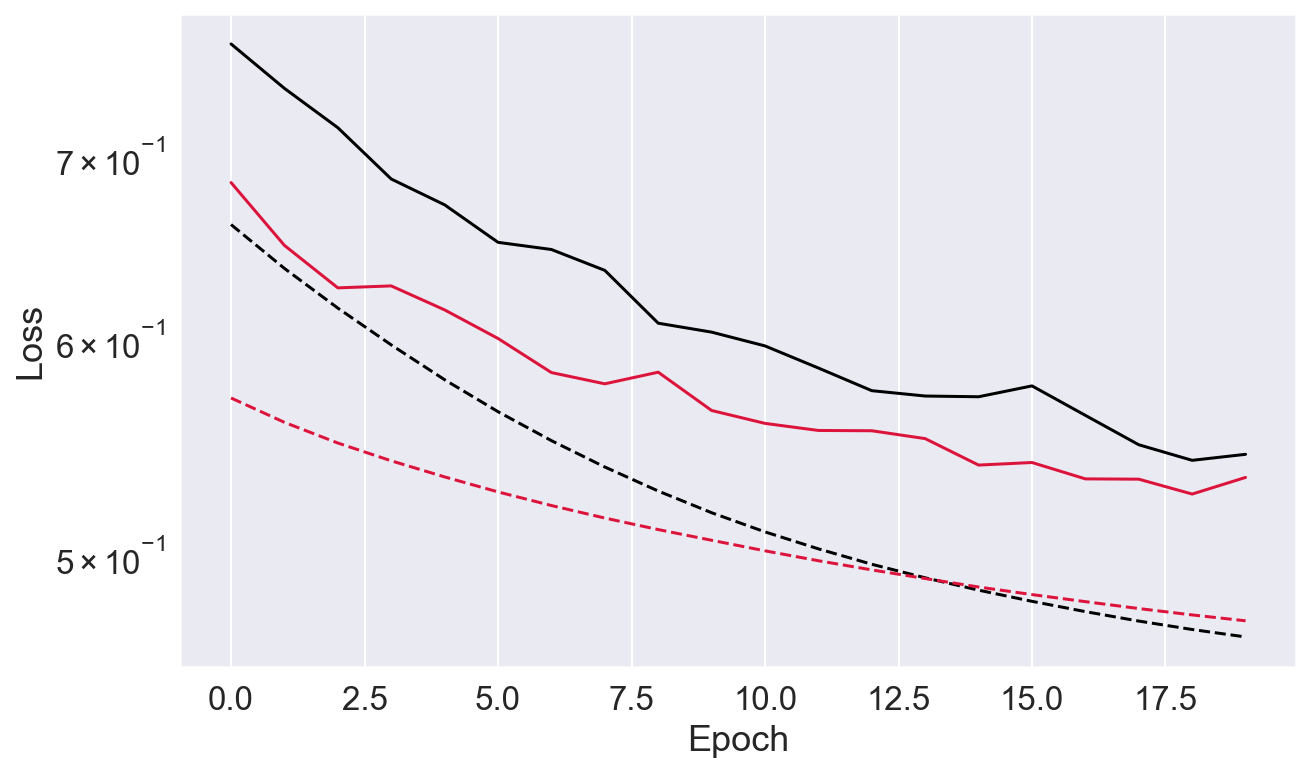

In [28]:
plt.figure(figsize=(10, 6))
PlotLoss(zero_bias_history, 'Zero Bias', 'black')
PlotLoss(careful_bias_history, 'Careful Bias', 'crimson')

In [29]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(validation_features, validation_labels))

Epoch 1/100
3/3 [==============================] - 2s 307ms/step - loss: 0.6706 - tp: 140.0000 - fp: 385.0000 - tn: 3745.0000 - fn: 1355.0000 - accuracy: 0.6907 - precision: 0.2667 - recall: 0.0936 - auc: 0.5703 - prc: 0.2988 - val_loss: 0.5715 - val_tp: 7.0000 - val_fp: 14.0000 - val_tn: 812.0000 - val_fn: 292.0000 - val_accuracy: 0.7280 - val_precision: 0.3333 - val_recall: 0.0234 - val_auc: 0.5934 - val_prc: 0.3075
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6576 - tp: 129.0000 - fp: 362.0000 - tn: 2942.0000 - fn: 1067.0000 - accuracy: 0.6824 - precision: 0.2627 - recall: 0.1079 - auc: 0.5266 - prc: 0.2728 - val_loss: 0.5596 - val_tp: 7.0000 - val_fp: 7.0000 - val_tn: 819.0000 - val_fn: 292.0000 - val_accuracy: 0.7342 - val_precision: 0.5000 - val_recall: 0.0234 - val_auc: 0.6286 - val_prc: 0.3380
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6436 - tp: 116.0000 - fp: 294.0000 - tn: 3010.0000 - fn: 1080.0000 - accuracy: 0.694

3/3 [==============================] - 0s 13ms/step - loss: 0.5227 - tp: 224.0000 - fp: 181.0000 - tn: 3123.0000 - fn: 972.0000 - accuracy: 0.7438 - precision: 0.5531 - recall: 0.1873 - auc: 0.7151 - prc: 0.4575 - val_loss: 0.4728 - val_tp: 20.0000 - val_fp: 3.0000 - val_tn: 823.0000 - val_fn: 279.0000 - val_accuracy: 0.7493 - val_precision: 0.8696 - val_recall: 0.0669 - val_auc: 0.8227 - val_prc: 0.6032
Epoch 21/100
3/3 [==============================] - 0s 15ms/step - loss: 0.5215 - tp: 232.0000 - fp: 182.0000 - tn: 3122.0000 - fn: 964.0000 - accuracy: 0.7453 - precision: 0.5604 - recall: 0.1940 - auc: 0.7167 - prc: 0.4627 - val_loss: 0.4705 - val_tp: 21.0000 - val_fp: 4.0000 - val_tn: 822.0000 - val_fn: 278.0000 - val_accuracy: 0.7493 - val_precision: 0.8400 - val_recall: 0.0702 - val_auc: 0.8243 - val_prc: 0.6077
Epoch 22/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5187 - tp: 237.0000 - fp: 182.0000 - tn: 3122.0000 - fn: 959.0000 - accuracy: 0.7464 - precision

3/3 [==============================] - 0s 12ms/step - loss: 0.4961 - tp: 334.0000 - fp: 226.0000 - tn: 3078.0000 - fn: 862.0000 - accuracy: 0.7582 - precision: 0.5964 - recall: 0.2793 - auc: 0.7630 - prc: 0.5085 - val_loss: 0.4434 - val_tp: 65.0000 - val_fp: 20.0000 - val_tn: 806.0000 - val_fn: 234.0000 - val_accuracy: 0.7742 - val_precision: 0.7647 - val_recall: 0.2174 - val_auc: 0.8392 - val_prc: 0.6364
Epoch 40/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4996 - tp: 298.0000 - fp: 247.0000 - tn: 3057.0000 - fn: 898.0000 - accuracy: 0.7456 - precision: 0.5468 - recall: 0.2492 - auc: 0.7616 - prc: 0.4873 - val_loss: 0.4425 - val_tp: 65.0000 - val_fp: 22.0000 - val_tn: 804.0000 - val_fn: 234.0000 - val_accuracy: 0.7724 - val_precision: 0.7471 - val_recall: 0.2174 - val_auc: 0.8399 - val_prc: 0.6381
Epoch 41/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4892 - tp: 341.0000 - fp: 220.0000 - tn: 3084.0000 - fn: 855.0000 - accuracy: 0.7611 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4729 - tp: 377.0000 - fp: 239.0000 - tn: 3065.0000 - fn: 819.0000 - accuracy: 0.7649 - precision: 0.6120 - recall: 0.3152 - auc: 0.7941 - prc: 0.5476 - val_loss: 0.4310 - val_tp: 81.0000 - val_fp: 30.0000 - val_tn: 796.0000 - val_fn: 218.0000 - val_accuracy: 0.7796 - val_precision: 0.7297 - val_recall: 0.2709 - val_auc: 0.8475 - val_prc: 0.6473
Epoch 59/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4715 - tp: 355.0000 - fp: 214.0000 - tn: 3090.0000 - fn: 841.0000 - accuracy: 0.7656 - precision: 0.6239 - recall: 0.2968 - auc: 0.7914 - prc: 0.5544 - val_loss: 0.4304 - val_tp: 83.0000 - val_fp: 30.0000 - val_tn: 796.0000 - val_fn: 216.0000 - val_accuracy: 0.7813 - val_precision: 0.7345 - val_recall: 0.2776 - val_auc: 0.8476 - val_prc: 0.6463
Epoch 60/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4763 - tp: 382.0000 - fp: 234.0000 - tn: 3070.0000 - fn: 814.0000 - accuracy: 0.7671 - precisi

3/3 [==============================] - 0s 15ms/step - loss: 0.4630 - tp: 354.0000 - fp: 223.0000 - tn: 3081.0000 - fn: 842.0000 - accuracy: 0.7633 - precision: 0.6135 - recall: 0.2960 - auc: 0.8034 - prc: 0.5662 - val_loss: 0.4232 - val_tp: 90.0000 - val_fp: 31.0000 - val_tn: 795.0000 - val_fn: 209.0000 - val_accuracy: 0.7867 - val_precision: 0.7438 - val_recall: 0.3010 - val_auc: 0.8505 - val_prc: 0.6541
Epoch 78/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4677 - tp: 375.0000 - fp: 229.0000 - tn: 3075.0000 - fn: 821.0000 - accuracy: 0.7667 - precision: 0.6209 - recall: 0.3135 - auc: 0.7993 - prc: 0.5571 - val_loss: 0.4226 - val_tp: 94.0000 - val_fp: 31.0000 - val_tn: 795.0000 - val_fn: 205.0000 - val_accuracy: 0.7902 - val_precision: 0.7520 - val_recall: 0.3144 - val_auc: 0.8506 - val_prc: 0.6554
Epoch 79/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4633 - tp: 382.0000 - fp: 226.0000 - tn: 3078.0000 - fn: 814.0000 - accuracy: 0.7689 - precisi

3/3 [==============================] - 0s 16ms/step - loss: 0.4624 - tp: 402.0000 - fp: 244.0000 - tn: 3060.0000 - fn: 794.0000 - accuracy: 0.7693 - precision: 0.6223 - recall: 0.3361 - auc: 0.8078 - prc: 0.5697 - val_loss: 0.4204 - val_tp: 100.0000 - val_fp: 32.0000 - val_tn: 794.0000 - val_fn: 199.0000 - val_accuracy: 0.7947 - val_precision: 0.7576 - val_recall: 0.3344 - val_auc: 0.8517 - val_prc: 0.6574
Epoch 97/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4589 - tp: 387.0000 - fp: 236.0000 - tn: 3068.0000 - fn: 809.0000 - accuracy: 0.7678 - precision: 0.6212 - recall: 0.3236 - auc: 0.8077 - prc: 0.5674 - val_loss: 0.4204 - val_tp: 100.0000 - val_fp: 32.0000 - val_tn: 794.0000 - val_fn: 199.0000 - val_accuracy: 0.7947 - val_precision: 0.7576 - val_recall: 0.3344 - val_auc: 0.8516 - val_prc: 0.6577
Epoch 98/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4562 - tp: 393.0000 - fp: 221.0000 - tn: 3083.0000 - fn: 803.0000 - accuracy: 0.7724 - preci

In [30]:
def PlotMetrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color='black', label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color='black', ls='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

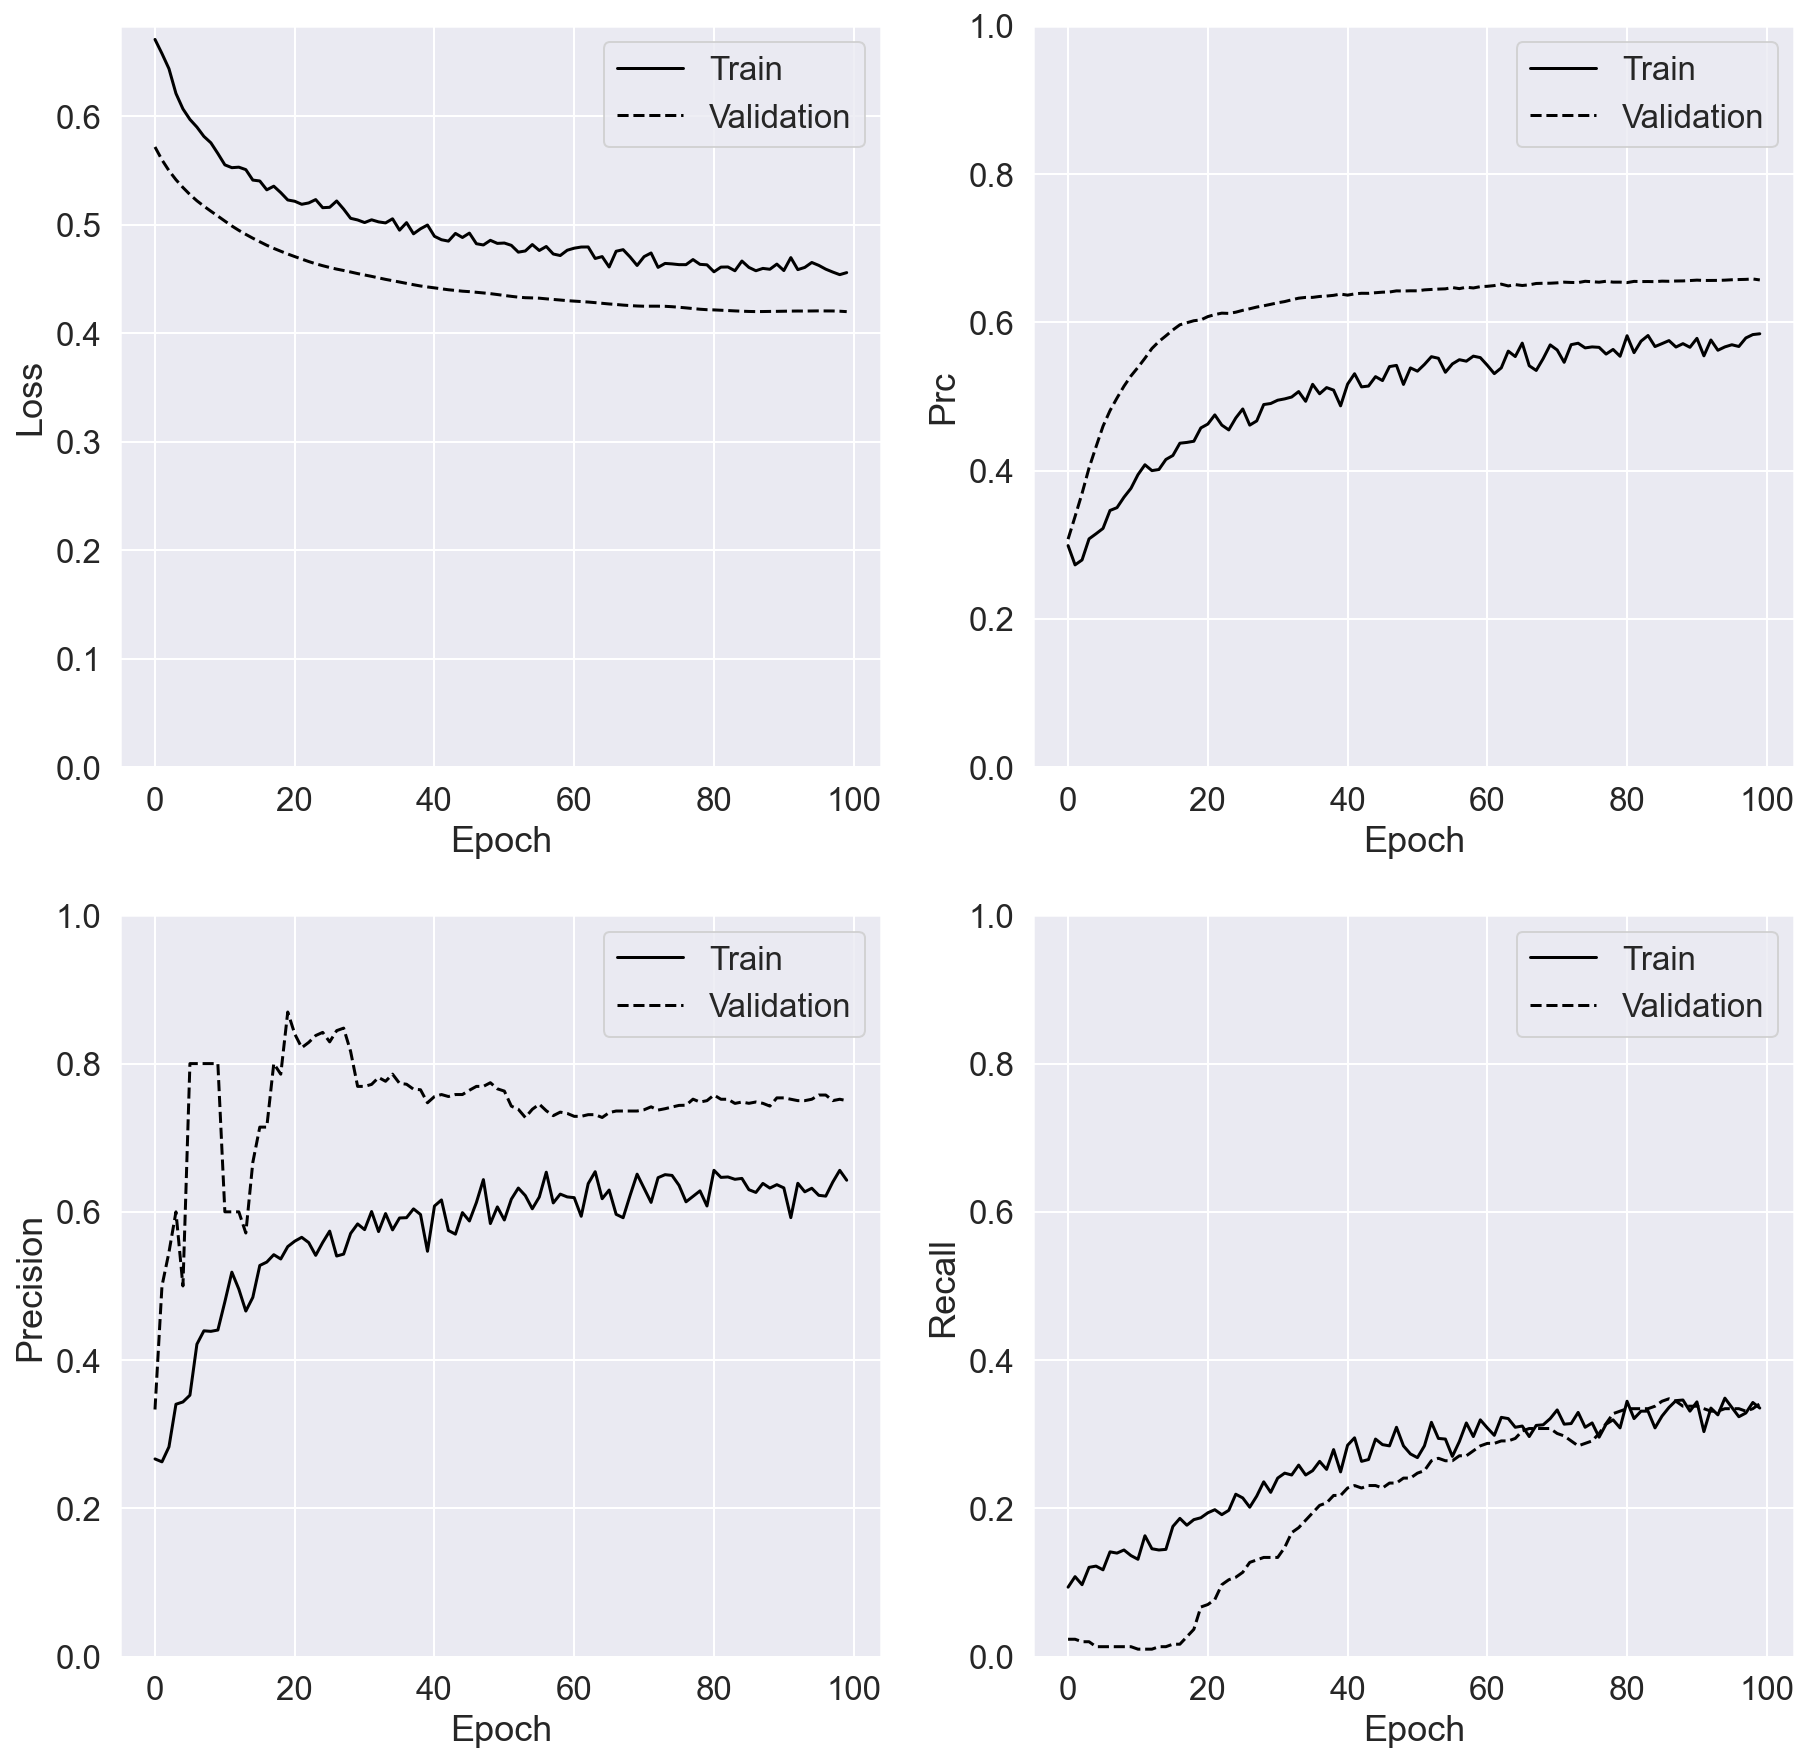

In [31]:
PlotMetrics(baseline_history)

In [32]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [33]:
def ConfMatrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.43682458996772766
tp :  114.0
fp :  39.0
tn :  994.0
fn :  260.0
accuracy :  0.7874911427497864
precision :  0.7450980544090271
recall :  0.30481284856796265
auc :  0.837307333946228
prc :  0.6446961164474487


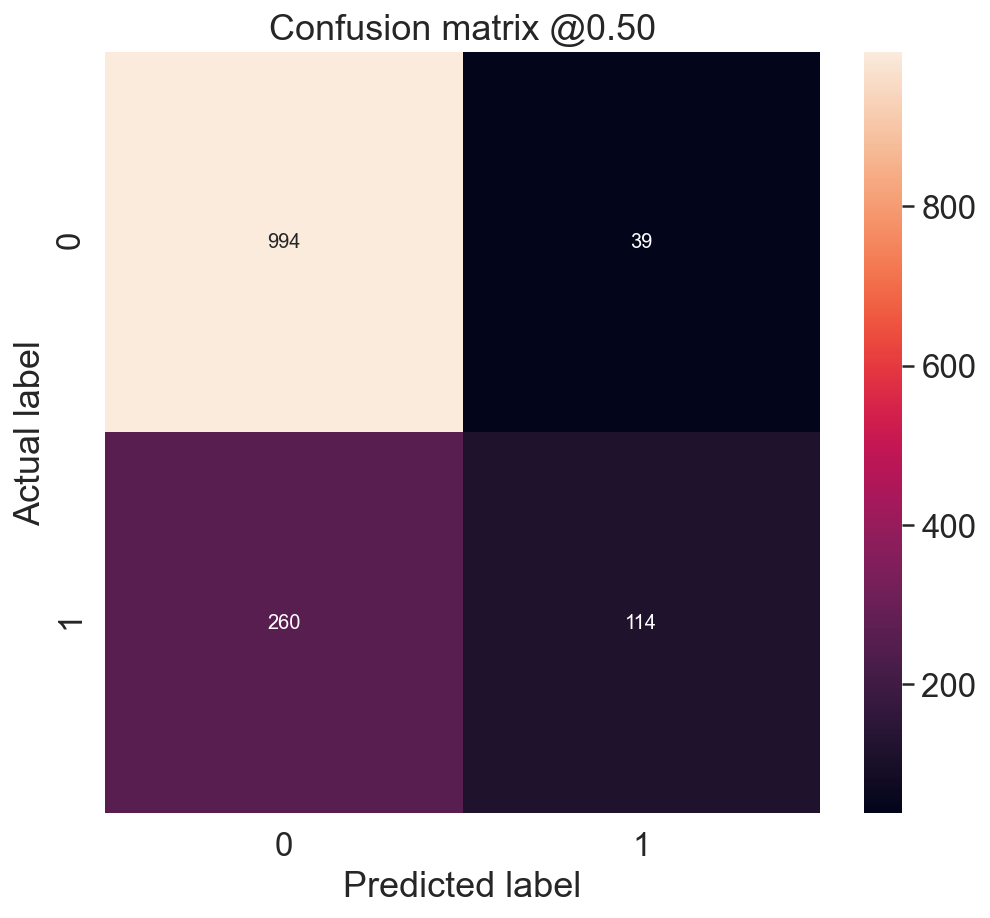

In [34]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_baseline)

In [35]:
def PlotROC(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

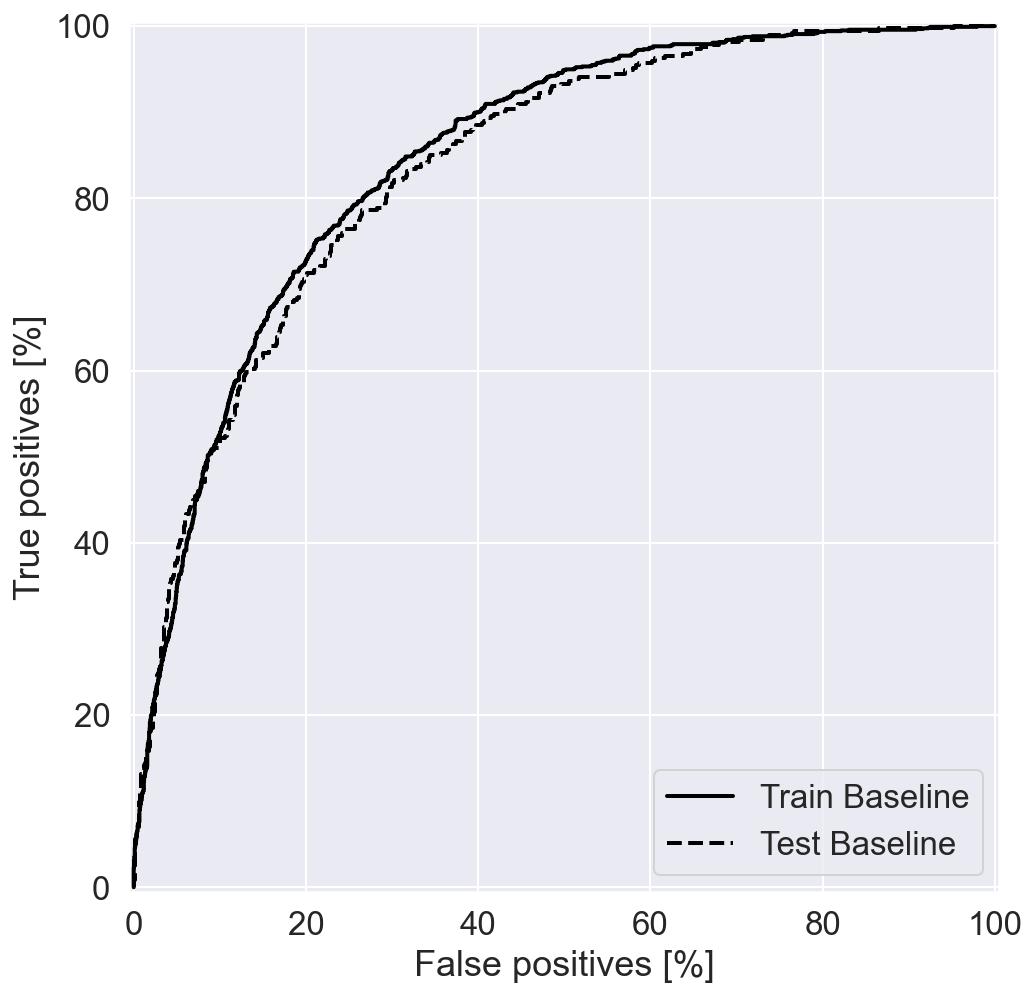

In [36]:
plt.figure(figsize=(8, 8))
PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower right')

In [37]:
def PlotPRC(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, lw=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

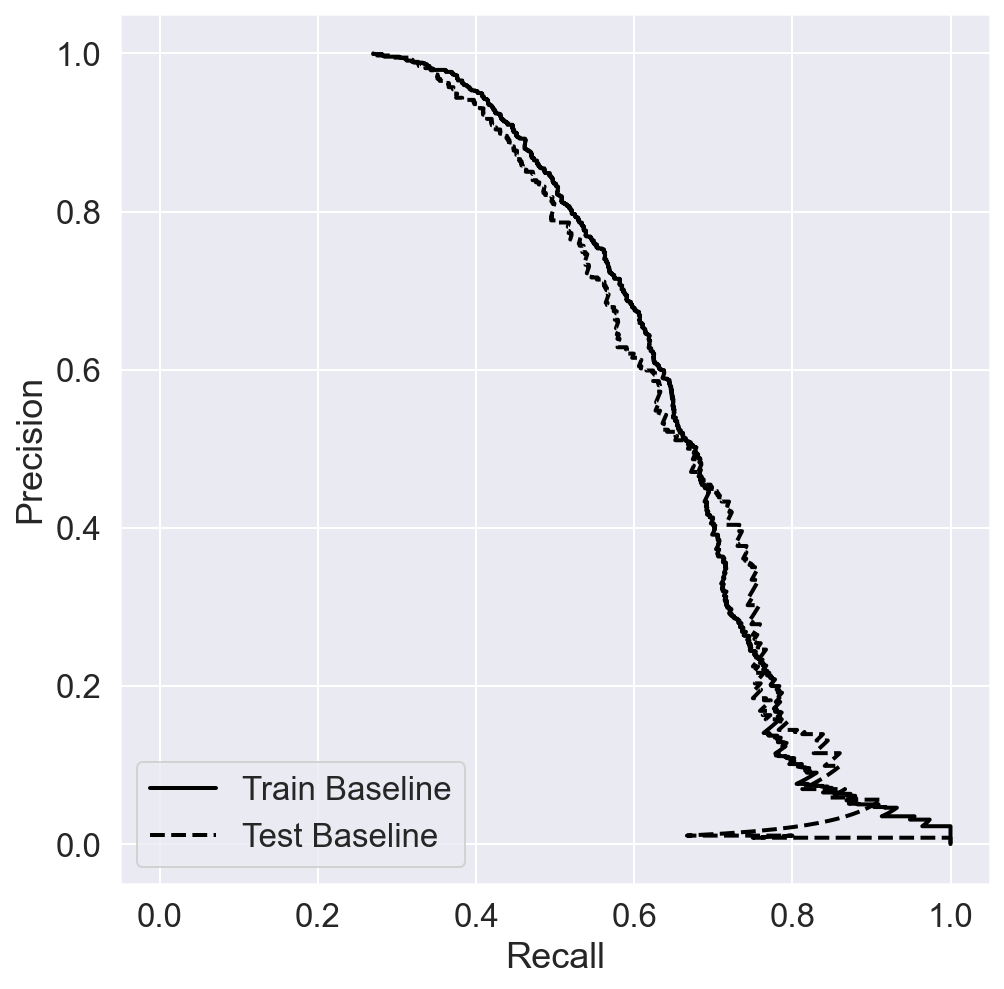

In [38]:
plt.figure(figsize=(8, 8))
PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower left')

In [39]:
weight_for_0 = (1/neg)*(total/2)
weight_for_1 = (1/pos)*(total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(validation_features, validation_labels),
                                      class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
3/3 [==============================] - 2s 350ms/step - loss: 0.9540 - tp: 223.0000 - fp: 415.0000 - tn: 3922.0000 - fn: 1347.0000 - accuracy: 0.7017 - precision: 0.3495 - recall: 0.1420 - auc: 0.5913 - prc: 0.3136 - val_loss: 0.5753 - val_tp: 13.0000 - val_fp: 24.0000 - val_tn: 802.0000 - val_fn: 286.0000 - val_accuracy: 0.7244 - val_precision: 0.3514 - val_recall: 0.0435 - val_auc: 0.5849 - val_prc: 0.3031
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.8970 - tp: 154.0000 - fp: 422.0000 - tn: 2882.0000 - fn: 1042.0000 - accuracy: 0.6747 - precision: 0.2674 - recall: 0.1288 - auc: 0.5318 - prc: 0.2742 - val_loss: 0.5676 - val_tp: 14.0000 - val_fp: 26.0000 - val_tn: 800.0000 - val_fn: 285.0000 - val_accuracy: 0.7236 - val_precision: 0.3500 - val_recall: 0.0468 - val_auc: 0.6106 - val_prc: 0.3276
Epoch 3/100
3/3 [

3/3 [==============================] - 0s 16ms/step - loss: 0.6698 - tp: 575.0000 - fp: 799.0000 - tn: 2505.0000 - fn: 621.0000 - accuracy: 0.6844 - precision: 0.4185 - recall: 0.4808 - auc: 0.6818 - prc: 0.4266 - val_loss: 0.5359 - val_tp: 199.0000 - val_fp: 170.0000 - val_tn: 656.0000 - val_fn: 100.0000 - val_accuracy: 0.7600 - val_precision: 0.5393 - val_recall: 0.6656 - val_auc: 0.8091 - val_prc: 0.5825
Epoch 20/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6666 - tp: 595.0000 - fp: 836.0000 - tn: 2468.0000 - fn: 601.0000 - accuracy: 0.6807 - precision: 0.4158 - recall: 0.4975 - auc: 0.6820 - prc: 0.4362 - val_loss: 0.5332 - val_tp: 201.0000 - val_fp: 169.0000 - val_tn: 657.0000 - val_fn: 98.0000 - val_accuracy: 0.7627 - val_precision: 0.5432 - val_recall: 0.6722 - val_auc: 0.8126 - val_prc: 0.5880
Epoch 21/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6483 - tp: 612.0000 - fp: 762.0000 - tn: 2542.0000 - fn: 584.0000 - accuracy: 0.7009 - prec

3/3 [==============================] - 0s 14ms/step - loss: 0.6075 - tp: 688.0000 - fp: 733.0000 - tn: 2571.0000 - fn: 508.0000 - accuracy: 0.7242 - precision: 0.4842 - recall: 0.5753 - auc: 0.7503 - prc: 0.4998 - val_loss: 0.4992 - val_tp: 208.0000 - val_fp: 173.0000 - val_tn: 653.0000 - val_fn: 91.0000 - val_accuracy: 0.7653 - val_precision: 0.5459 - val_recall: 0.6957 - val_auc: 0.8374 - val_prc: 0.6332
Epoch 39/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6080 - tp: 706.0000 - fp: 716.0000 - tn: 2588.0000 - fn: 490.0000 - accuracy: 0.7320 - precision: 0.4965 - recall: 0.5903 - auc: 0.7523 - prc: 0.5079 - val_loss: 0.4979 - val_tp: 207.0000 - val_fp: 172.0000 - val_tn: 654.0000 - val_fn: 92.0000 - val_accuracy: 0.7653 - val_precision: 0.5462 - val_recall: 0.6923 - val_auc: 0.8381 - val_prc: 0.6341
Epoch 40/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6069 - tp: 689.0000 - fp: 712.0000 - tn: 2592.0000 - fn: 507.0000 - accuracy: 0.7291 - preci

3/3 [==============================] - 0s 13ms/step - loss: 0.5795 - tp: 729.0000 - fp: 711.0000 - tn: 2593.0000 - fn: 467.0000 - accuracy: 0.7382 - precision: 0.5063 - recall: 0.6095 - auc: 0.7774 - prc: 0.5375 - val_loss: 0.4872 - val_tp: 215.0000 - val_fp: 174.0000 - val_tn: 652.0000 - val_fn: 84.0000 - val_accuracy: 0.7707 - val_precision: 0.5527 - val_recall: 0.7191 - val_auc: 0.8473 - val_prc: 0.6468
Epoch 58/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5788 - tp: 745.0000 - fp: 714.0000 - tn: 2590.0000 - fn: 451.0000 - accuracy: 0.7411 - precision: 0.5106 - recall: 0.6229 - auc: 0.7812 - prc: 0.5386 - val_loss: 0.4878 - val_tp: 215.0000 - val_fp: 176.0000 - val_tn: 650.0000 - val_fn: 84.0000 - val_accuracy: 0.7689 - val_precision: 0.5499 - val_recall: 0.7191 - val_auc: 0.8476 - val_prc: 0.6494
Epoch 59/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5929 - tp: 728.0000 - fp: 745.0000 - tn: 2559.0000 - fn: 468.0000 - accuracy: 0.7304 - preci

3/3 [==============================] - 0s 13ms/step - loss: 0.5633 - tp: 733.0000 - fp: 712.0000 - tn: 2592.0000 - fn: 463.0000 - accuracy: 0.7389 - precision: 0.5073 - recall: 0.6129 - auc: 0.7916 - prc: 0.5510 - val_loss: 0.4781 - val_tp: 217.0000 - val_fp: 170.0000 - val_tn: 656.0000 - val_fn: 82.0000 - val_accuracy: 0.7760 - val_precision: 0.5607 - val_recall: 0.7258 - val_auc: 0.8502 - val_prc: 0.6565
Epoch 77/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5600 - tp: 768.0000 - fp: 700.0000 - tn: 2604.0000 - fn: 428.0000 - accuracy: 0.7493 - precision: 0.5232 - recall: 0.6421 - auc: 0.7955 - prc: 0.5583 - val_loss: 0.4783 - val_tp: 217.0000 - val_fp: 170.0000 - val_tn: 656.0000 - val_fn: 82.0000 - val_accuracy: 0.7760 - val_precision: 0.5607 - val_recall: 0.7258 - val_auc: 0.8504 - val_prc: 0.6587
Epoch 78/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5658 - tp: 772.0000 - fp: 729.0000 - tn: 2575.0000 - fn: 424.0000 - accuracy: 0.7438 - preci

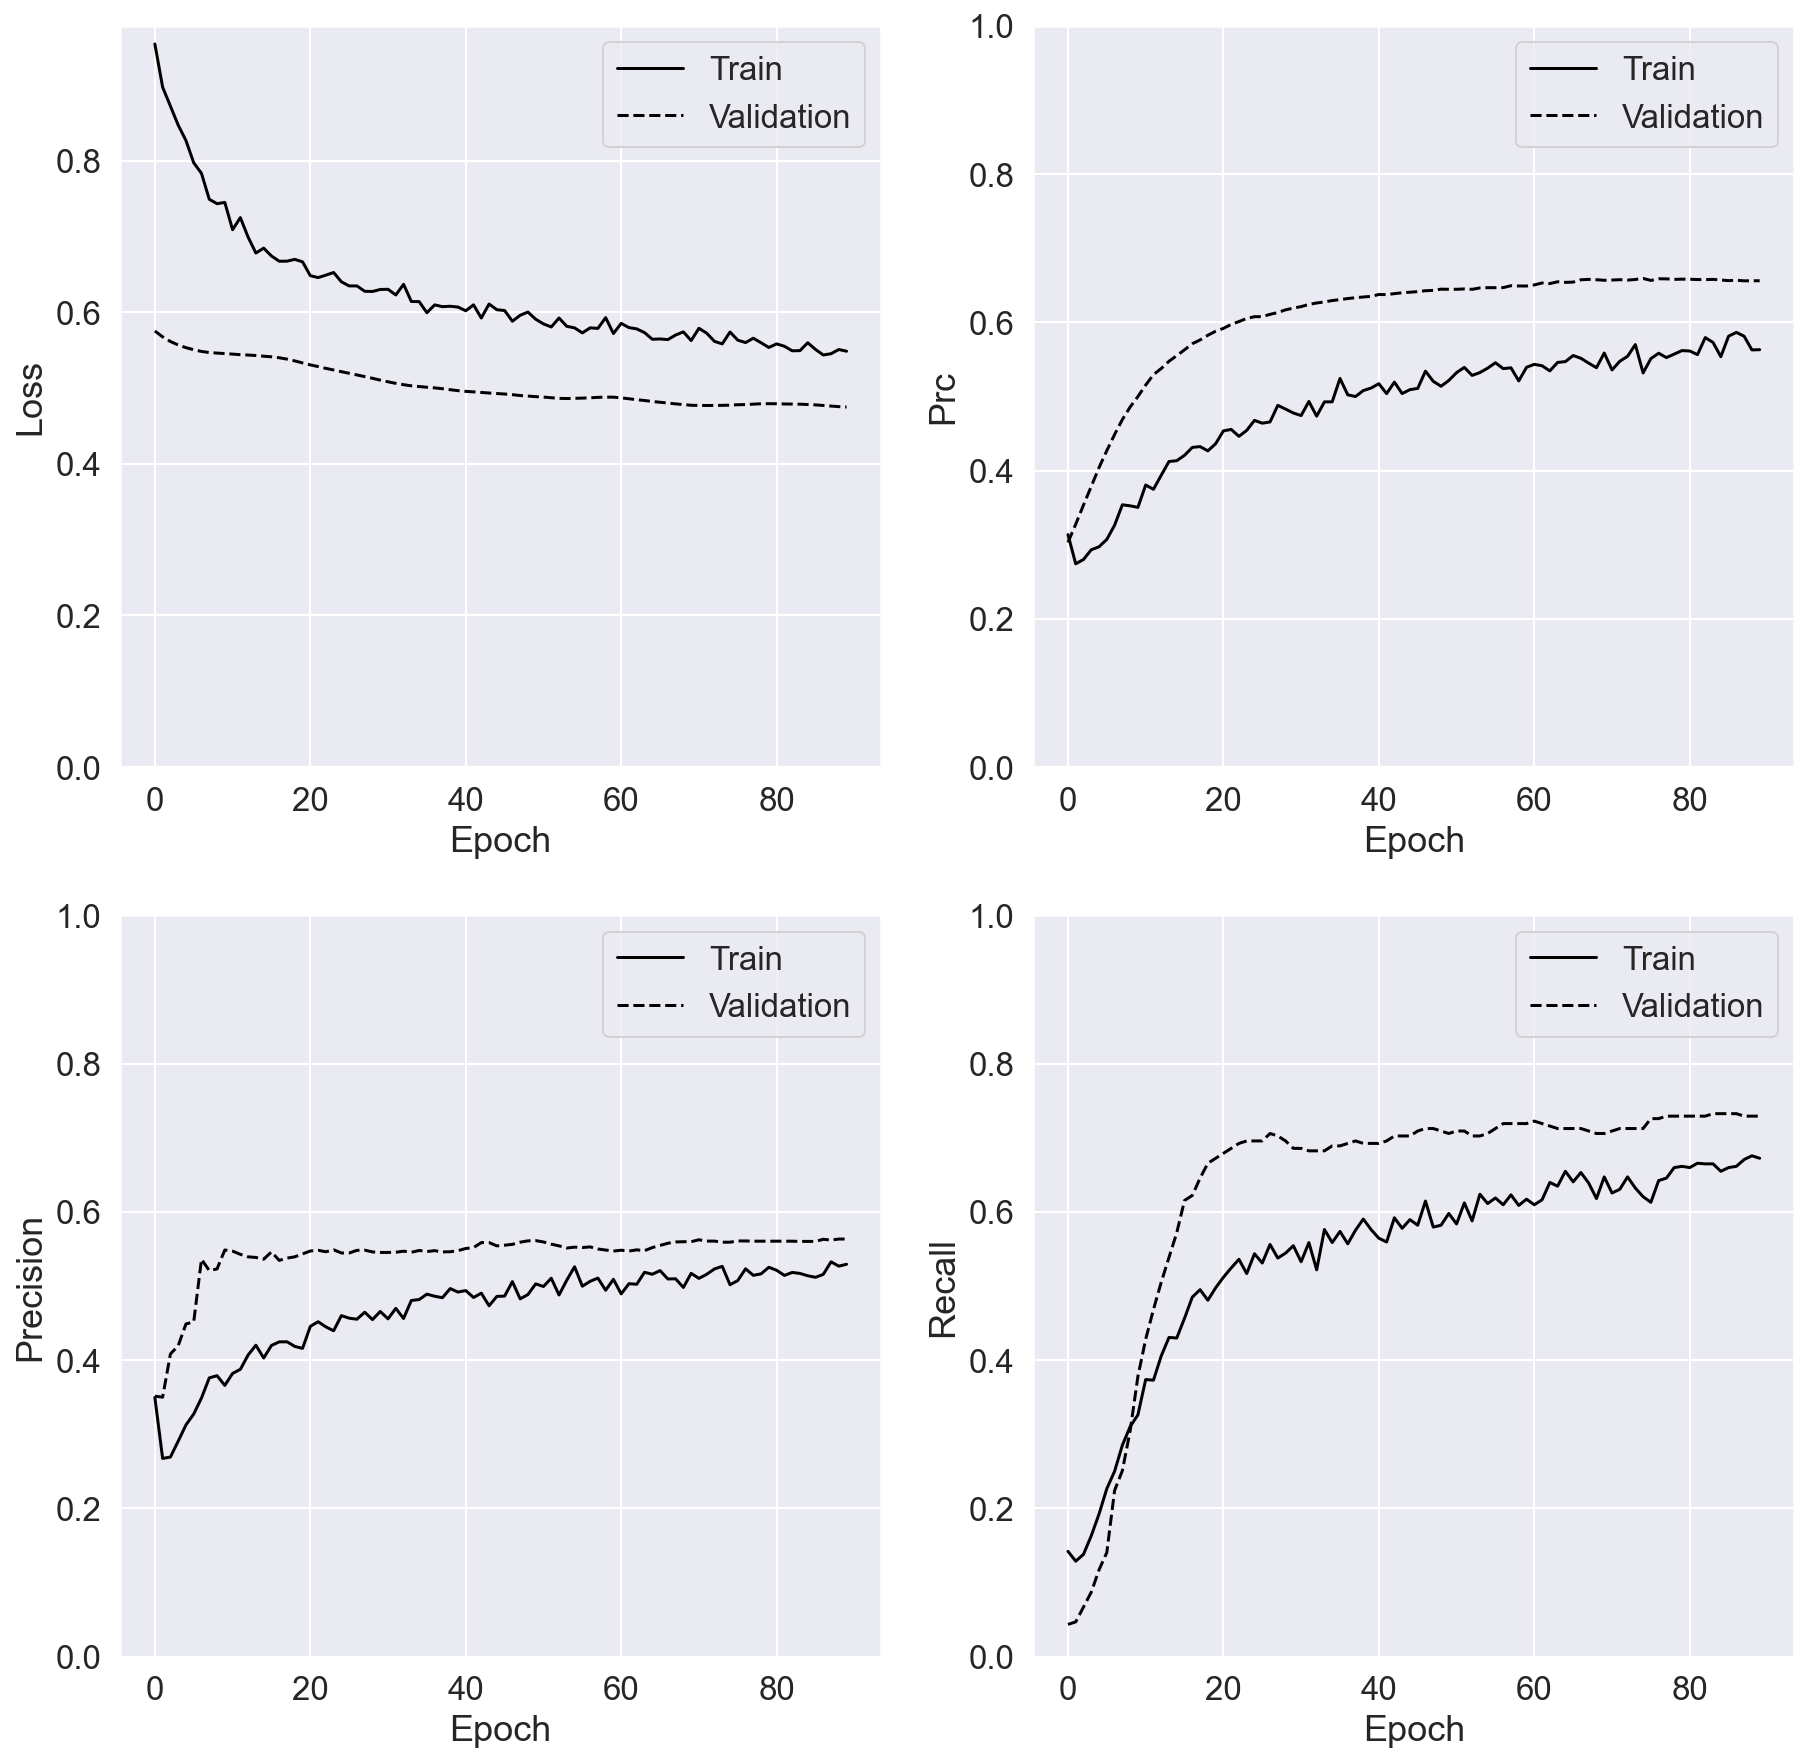

In [41]:
PlotMetrics(weighted_history)

In [42]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4960620105266571
tp :  270.0
fp :  221.0
tn :  812.0
fn :  104.0
accuracy :  0.7690120935440063
precision :  0.5498981475830078
recall :  0.7219251394271851
auc :  0.8347629904747009
prc :  0.6406821608543396


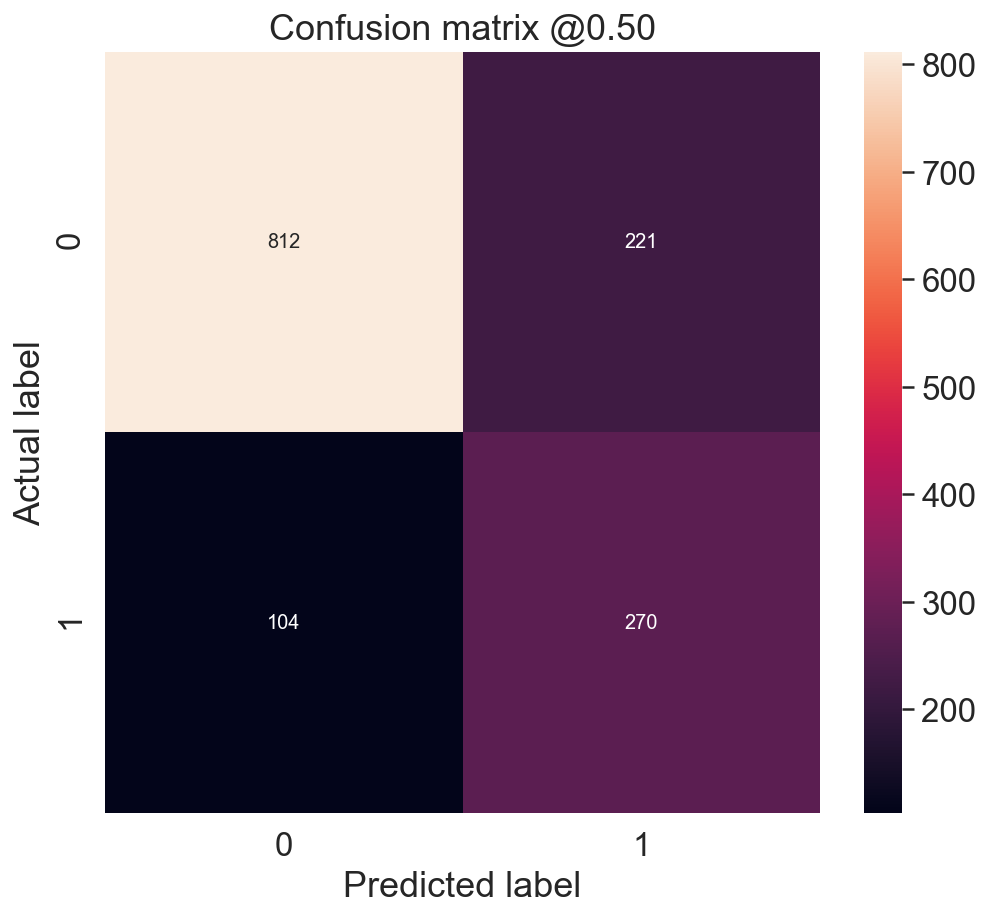

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_weighted)

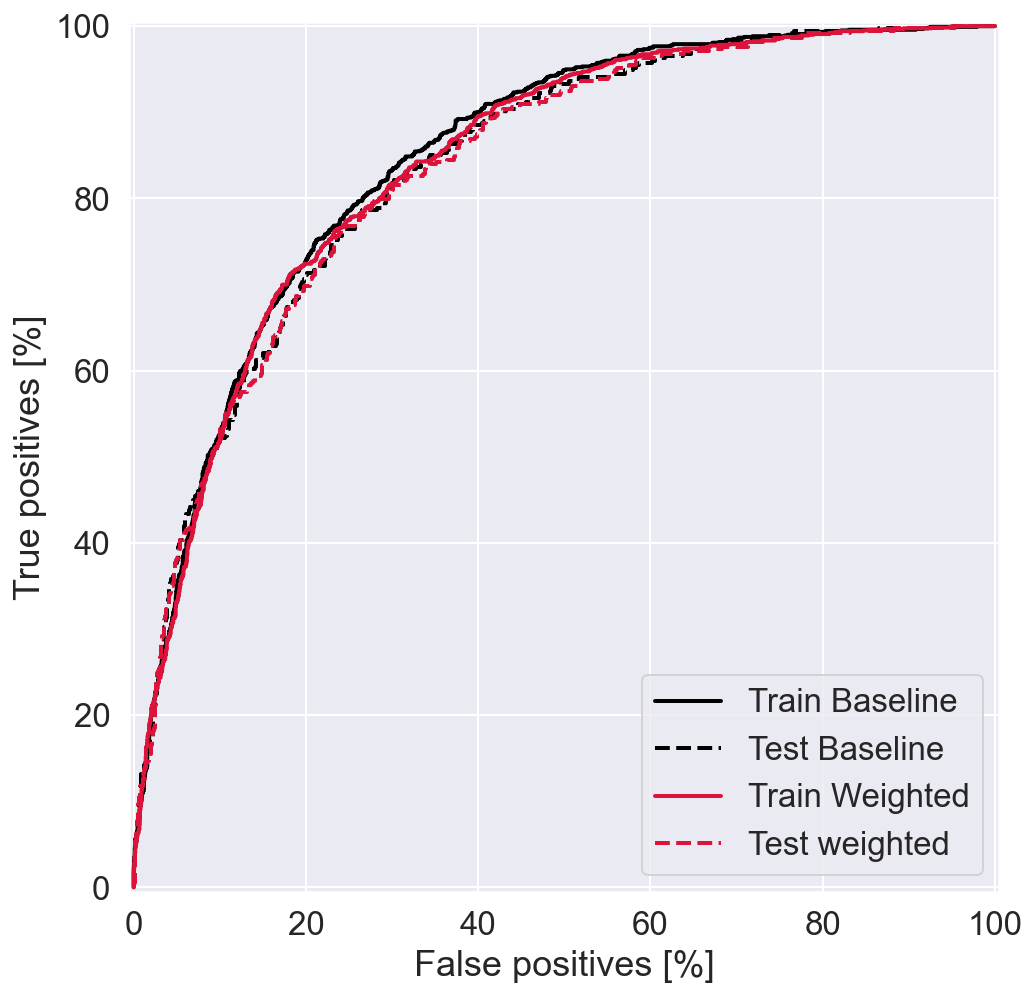

In [44]:
plt.figure(figsize=(8, 8))

PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotROC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotROC('Test weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower right')

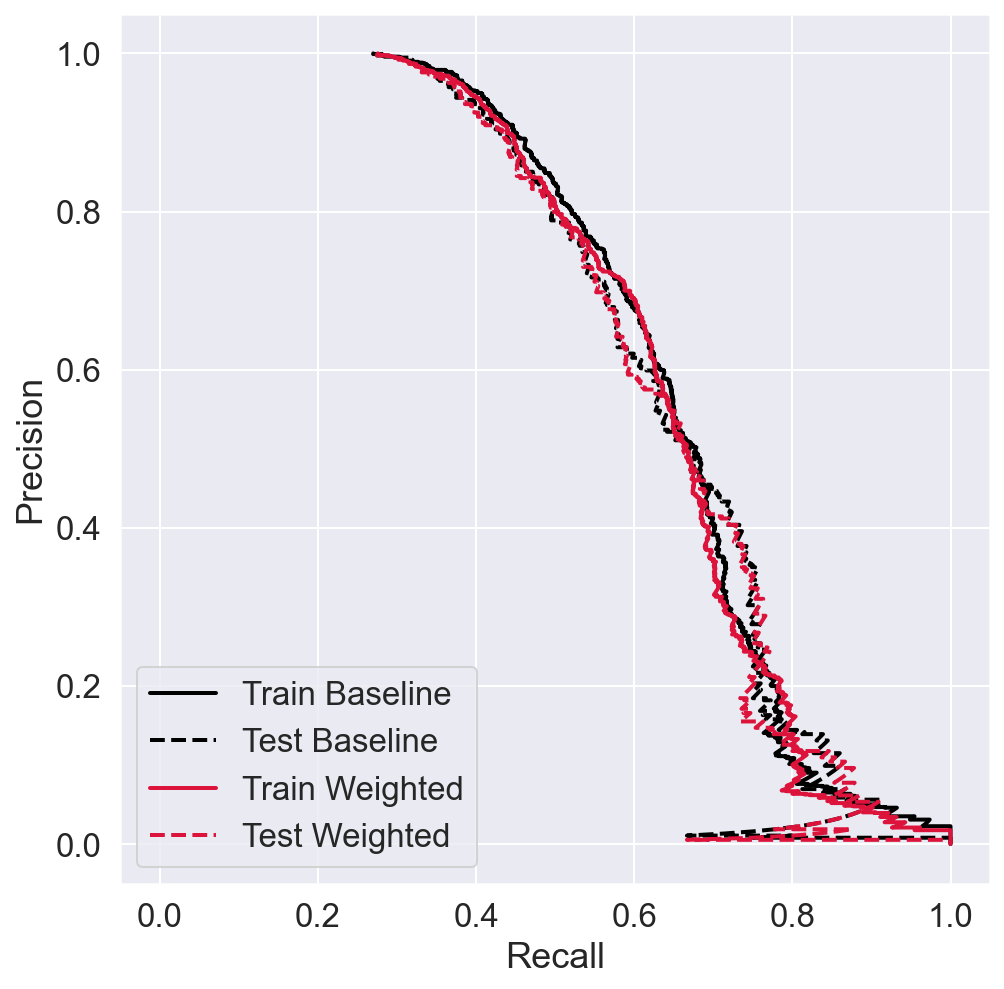

In [45]:
plt.figure(figsize=(8, 8))

PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotPRC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotPRC('Test Weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower left')